# Off-policy Learning in Contextual Bandits 

** *

This IPython notebook illustrates the usage of the [contextualbandits](https://www.github.com/david-cortes/contextualbandits) package's `offpolicy` module through a simulation with a public dataset.


** Small note: if the TOC here is not clickable or the math symbols don't show properly, try visualizing this same notebook from nbviewer following [this link](http://nbviewer.jupyter.org/github/david-cortes/contextualbandits/blob/master/example/offpolicy_learning.ipynb). **

** *

### Sections 

[1. Problem description](#p1)

[2. Algorithms](#p2)

[3. Experiments](#p3)

[4. References](#p4)

** * 

<a id="p1"></a>
## 1. Problem description

For a general description of the contextual bandits problem, see the first part of the package's guide [Online Contextual Bandits](http://nbviewer.jupyter.org/github/david-cortes/contextualbandits/blob/master/example/online_contextual_bandits.ipynb).

Unlike the `online` module mentioned above, this module deals with a slightly different problem: once we have collected (biased) data following some policy – consisting in features observed, actions chosen, rewards observed, and ideally scores or estimated rewards probabilities that the exploration policy predicted – how can we now build a different and perhaps better policy? (also known as "Off-policy learning").

This module focuses on building non-online, exploit-only policies, and unfortunately, the algorithms don't extend nicely to the case of classifiers that allow some exploration. It assumes a stationary exploration policy (non-online) for the methods to work well in theory, but in practice they can also work with data collected through online policies whose reward estimates shift over time (albeit performance is worse).
 

In the multi-label case with full information, this is straight-forward - we just fit the algorithm on all the data and then make predictions, but this logic doesn't extend so well to censored labels (i.e. knowing only whether the label that was chosen as correct), as the better the policy, the more biased the data becomes, and new policies might just end up imitating the old one.

The simplest approach would be to build a One-Vs-Rest classifier taking for each class only the data consisting of that action (if we know that observations always have at most 1 label, we can also take all the other data that got a reward and was not the action for which the classifier is being built as negative examples, but this is not a typical situation). However, we can also make use of the estimated rewards from the policy that generated the data in order to come up with less biased algorithms.

The approaches implemented here are just for comparison purposes. In practice, the naive One-Vs-Rest approach can perform better than the approaches described here, especially for the case of discrete rewards, and typical settings such as online advertising call for online algorithms.

** *
<a id="p2"></a>
## 2. Algorithms

The methods implemented here are:

* `OffsetTree` (see _The offset tree for learning with partial labels_).

* `DoublyRobustEstimator` (see _Doubly robust policy evaluation and learning_). Note that this method is meant for continuous rewards and doesn't work very well with discrete rewards. Also note that it is very computationally demanding.
 

In the author's own words: 

Offset Tree:
> The Offset Tree uses the following trick, which is easiest to understand in the case of k = 2 choices . When the observed reward $r_a$ of choice a is low, we essentially pretend that the other choice $a′$ was chosen and a different reward $r_{a′}$ was observed. Precisely how this is done and why, is driven by the regret analysis.

Doubly-Robust Estimator:
> Informally, the estimator uses (estimated_reward) as a baseline and if there is data available, a correction is applied. We will see that our estimator is accurate if at least one of the estimators (reward_estimate) and (probability_estimate), is accurate, hence the name doubly robust.
 

Just like in the online module, these are also meta-heuristics that take a binary classification algorithm supporting sample weights as a base oracle. For the case of `DoublyRobustEstimator`, which converts the problem into cost-sensitive classification, you need to pass a regressor rather than a classifier when using method `RegressionOneVsRest` (picked by default).

(For more information, see the references section at the end)

** * 
<a id="p3"></a>
## 3. Experiments

The experiments here are run on the same Bibtext dataset as in the guide for the online module.


In order to simulate a stationary (and biased) data collection policy, I will fit a logistic regression model with a sample of the **fully-labeled** data, then let it choose actions for some more data, and take those actions and rewards as input for a new policy, along with the estimated reward probabilities for the actions that were chosen. Note that this is done just to choose the actions of the data on which further policies will be built, and the full labels will not be available to these policies.

Some of the online algorithms in this package also allow an `output_score` argument to their `predict` function which can be used to generate this type of data (for more information see the individual documentation of each policy, e.g. `help(contextualbandits.online.BootstrappedTS)`).

The evaluation is done with a test set with the full labels available. For the problem of evaluating policies based on partially-labeled data see the other IPython notebook [Policy Evaluation in Contextual Bandits](http://nbviewer.jupyter.org/github/david-cortes/contextualbandits/blob/master/example/policy_evaluation.ipynb).

** * 
Loading the Bibtex dataset again:

In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

features=list()
labels=list()
with open('Bibtex_data.txt','rt') as f:
    f.readline()
    for l in f:
        if bool(re.search("^[0-9]",l)):
            g=re.search("^(([0-9]{1,2},?)+)\s(.*)$",l)
            labels.append([int(i) for i in g.group(1).split(",")])
            features.append(eval("{"+re.sub("\s",",",g.group(3))+"}"))
        else:
            l=l.strip()
            labels.append([])
            features.append(eval("{"+re.sub("\s",",",l)+"}"))
features=pd.DataFrame.from_dict(features).fillna(0).as_matrix()

mlb=MultiLabelBinarizer()
y=mlb.fit_transform(labels)
print(features.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


Simulating a stationary exploration policy:

In [2]:
from sklearn.linear_model import LogisticRegression

# the 'explorer' polcy will be fit with this small sample of the rows
st_seed=0
end_seed=3000

# then it will choose actions for this larger sample
st_exploration=0
end_exploration=5000

# the new policy will be evaluated with a separate test set
st_test=5000
end_test=7395

# separating the covariates data for each case
Xseed=features[st_seed:end_seed,:]
Xexplore_sample=features[st_exploration:end_exploration,:]
Xtest=features[st_test:end_test,:]
nchoices=y.shape[1]

# now constructing an exploration policy as explained above, with fully-labeled data
explorer=LogisticRegression()
explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

# letting the exploration policy choose actions for the new policy input
actions_explore_sample=explorer.predict(Xexplore_sample)
rewards_explore_sample=y[st_exploration:end_exploration,:]\
                    [np.arange(end_exploration-st_exploration),actions_explore_sample]

# extracting the probabilities it estimated
ix_internal_actions={j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions=[ix_internal_actions[i] for i in actions_explore_sample]
ix_internal_actions=np.array(ix_internal_actions)
prob_actions_explore=explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),ix_internal_actions]


Naïve solution: separate classifiers using subsets of the data:

In [3]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(), nchoices=y.shape[1])
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_naive = np.mean(y[st_test:end_test,:][np.arange(end_test-st_test),new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers: ", mean_reward_naive)

Test set mean reward - Separate Classifiers:  0.3298538622129436


Now trying the offset tree method:

In [4]:
from contextualbandits.offpolicy import OffsetTree
from sklearn.linear_model import LogisticRegression

new_policy = OffsetTree(base_algorithm=LogisticRegression(), nchoices=y.shape[1])
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_ot = np.mean(y[st_test:end_test,:][np.arange(end_test-st_test),new_policy.predict(Xtest)])
print("Test set mean reward - Offset Tree technique: ", mean_reward_ot)

Test set mean reward - Offset Tree technique:  0.3060542797494781


Performance is quite similar to how it was before, and it didn't manage to bet the naive method. However, this is quite an unfair comparison, as there are many arms that the exploration policy didn't choose even once, so the offset tree has to sometimes decide between classes for which no data is available.
** *
The doubly-robust method can also be tried for the case of discrete rewards, where the reward estimates are the same probability estimates from the base algorithm. However, its performance is not as good:

In [5]:
from contextualbandits.offpolicy import DoublyRobustEstimator
from sklearn.linear_model import LogisticRegression, Ridge

new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(),
                                   nchoices = y.shape[1],
                                   method = 'rovr')
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr = np.mean(y[st_test:end_test,:][np.arange(end_test-st_test),new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator: ", mean_reward_dr)

Test set mean reward - Doubly-Robust Estimator:  0.08475991649269311


Unfortunately, it also didn't manage to improve the estimates - which is not surprising given that the method is meant for the continuous reward scenario rather than the discrete rewards as shown here.

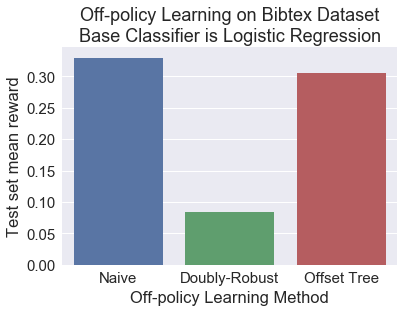

In [6]:
import matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline

results = pd.DataFrame({
    'Off-policy Learning Method' : ['Naive', 'Doubly-Robust', 'Offset Tree'],
    'Test set mean reward' : [mean_reward_naive, mean_reward_dr, mean_reward_ot]
})

sns.set(font_scale=1.5)
sns.barplot(x="Off-policy Learning Method", y="Test set mean reward", data=results)
plt.title('Off-policy Learning on Bibtex Dataset\nBase Classifier is Logistic Regression')
plt.show()

** * 
<a id="p4"></a>

## References:

* Beygelzimer, A., & Langford, J. (2009, June). The offset tree for learning with partial labels. In Proceedings of the 15th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 129-138). ACM.

* Dudík, M., Langford, J., & Li, L. (2011). Doubly robust policy evaluation and learning. arXiv preprint arXiv:1103.4601.

* Dudík, M., Erhan, D., Langford, J., & Li, L. (2014). Doubly robust policy evaluation and optimization. Statistical Science, 485-511.